In [1]:
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../../'))
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wave
from tqdm import tqdm
import glob
import torch
from Audio_Sentiment_Analysis.utils.vscode_audio import Audio
from Audio_Sentiment_Analysis.ser_tools.ser_classifier import SERClassifier
from sklearn import preprocessing

AUDIO_DIR = f"{os.path.abspath('./../../../')}/IEMOCAP_Dataset"
AUDIO_CLASSIFIER_MODEL = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/ser_tools/traditional_model.pkl"

torch.set_num_threads(1)
plt.rcParams['figure.dpi'] = 300

# Loading File from IEMOCAP

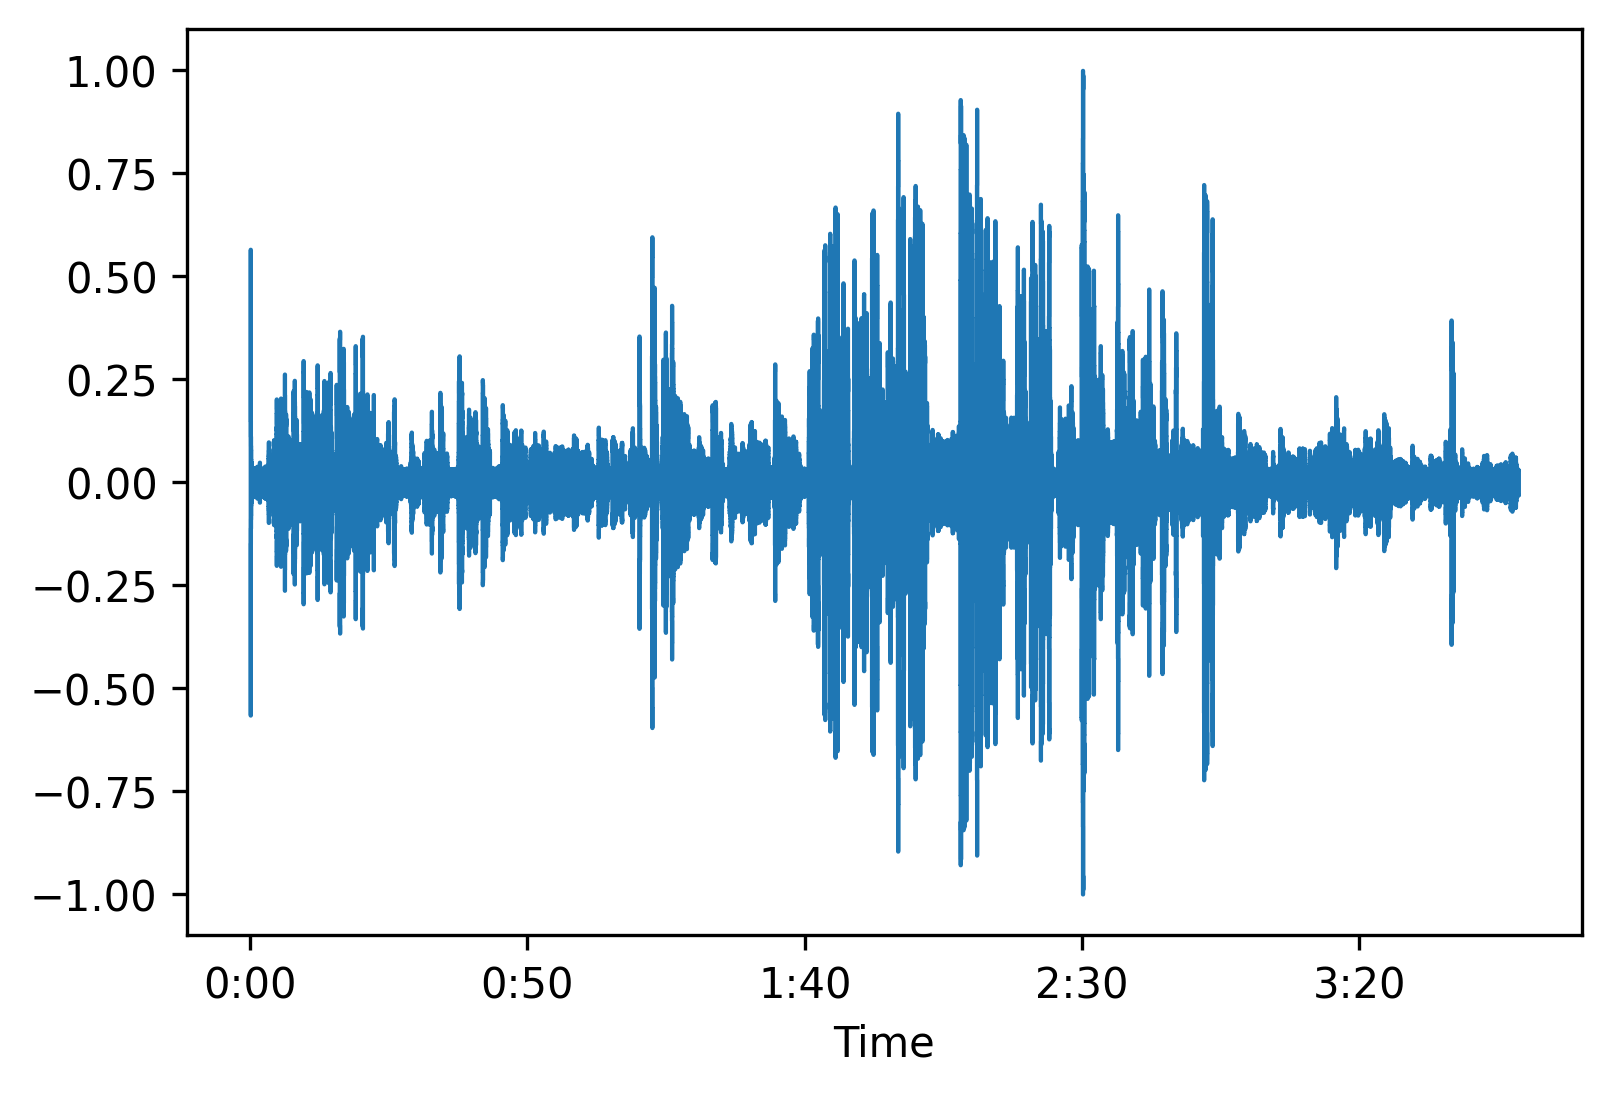

In [2]:
audio_file_test = AUDIO_DIR+'/Session1/dialog/wav/Ses01F_impro05.wav'
y, sr = librosa.load(audio_file_test, sr=16000)
y_to_print = preprocessing.minmax_scale(y, feature_range=(-1, 1))
librosa.display.waveshow(y_to_print, sr=sr)
plt.show()

In [3]:
all_voiced_frames = []
male_voiced_frames = []
female_voiced_frames = []
seg_emot = []
with open(AUDIO_DIR+'/Session1/dialog/EmoEvaluation/Ses01F_impro05.txt') as emotions_test_file:
    for line in emotions_test_file:
        if line[0] == '[':
            args = line.split()
            if 'M' == args[3][-4]:
                male_voiced_frames.append((float(args[0][1:]), float(args[2][:-1])))
            else:
                female_voiced_frames.append((float(args[0][1:]), float(args[2][:-1])))
            all_voiced_frames.append((float(args[0][1:]), float(args[2][:-1])))
            seg_emot.append(args[4])
seg_emot = [x if x != 'exc' else 'hap' for x in seg_emot]
all_voiced_frames.sort(key=lambda x: x[0])

In [4]:
# These have both female and male actors speech times
print(f"Number of separate actors voice frames: {len(all_voiced_frames)}")
print(all_voiced_frames)

Number of separate actors voice frames: 67
[(3.61, 5.19), (4.24, 5.23), (5.21, 6.44), (5.26, 7.16), (6.6, 7.71), (7.35, 8.85), (8.32, 9.8), (9.2, 13.02), (12.26, 13.78), (13.04, 22.74), (21.84, 25.9), (25.35, 26.76), (25.99, 27.7272), (28.24, 29.91), (28.29, 34.1425), (32.19, 33.5), (33.78, 35.9), (34.7, 36.52), (36.71, 44.03), (36.91, 42.76), (43.86, 49.97), (49.97, 70.26), (69.55, 73.76), (70.38, 73.14), (73.55, 74.99), (73.87, 75.5375), (75.03, 76.48), (75.61, 80.73), (80.22, 83.2425), (82.75, 86.06), (85.72, 93.9575), (94.005, 100.4), (99.52, 102.9), (100.55, 103.68), (103.005, 118.5), (111.28, 112.81), (118.04, 119.37), (118.53, 122.44), (121.19, 129.23), (127.485, 136.85), (131.02, 133.25), (136.19, 143.5), (137.715, 140.11), (140.225, 145.6), (144.85, 151.16), (149.365, 153.8), (151.335, 152.71), (152.8325, 158.58), (155.6, 160.36), (159.66, 161.37), (160.41, 163.7975), (163.25, 166.99), (163.88, 165.8), (166.33, 167.71), (167.15, 173.63), (171.09, 174.2), (173.7325, 178.2625), 

In [5]:
# Here we have both female and male actors speech times combined
# while not allowing differences between frames to be inferior than 1 second
min_frame_duration = 1 # duration in seconds

combined_voiced_frames = []
prev_start, prev_end = all_voiced_frames[0]
for start, end in all_voiced_frames[1:]:
    if start - prev_end <= min_frame_duration:
        prev_end = end
    else:
        combined_voiced_frames.append((prev_start, prev_end))
        prev_start, prev_end = start, end
combined_voiced_frames.append((prev_start, prev_end))
combined_voiced_frames.sort(key=lambda x: x[0])
processed_combined_voiced_frames = []
for x in combined_voiced_frames:
    while ((x[1] - x[0]) > 6):
        processed_combined_voiced_frames.append((x[0], x[0]+6))
        x = (x[0]+6, x[1])
    if (x[1] - x[0]) >= 1:
        processed_combined_voiced_frames.append(x)
print(f"Number of combined actors voice frames: {len(processed_combined_voiced_frames)}")
print(processed_combined_voiced_frames)

Number of combined actors voice frames: 35
[(3.61, 9.61), (9.61, 15.61), (15.61, 21.61), (21.61, 27.61), (27.61, 33.61), (33.61, 39.61), (39.61, 42.76), (43.86, 49.86), (49.86, 55.86), (55.86, 61.86), (61.86, 67.86), (67.86, 73.86), (73.86, 79.86), (79.86, 85.86), (85.86, 91.86), (91.86, 97.86), (97.86, 103.86), (103.86, 109.86), (109.86, 112.81), (118.04, 124.04), (124.04, 130.04000000000002), (130.04000000000002, 133.25), (136.19, 142.19), (142.19, 148.19), (148.19, 154.19), (154.19, 160.19), (160.19, 166.19), (166.19, 172.19), (172.19, 178.19), (178.19, 184.19), (184.19, 190.19), (190.19, 196.19), (196.19, 202.19), (202.19, 208.19), (208.19, 211.94)]


# File Voiced Frames

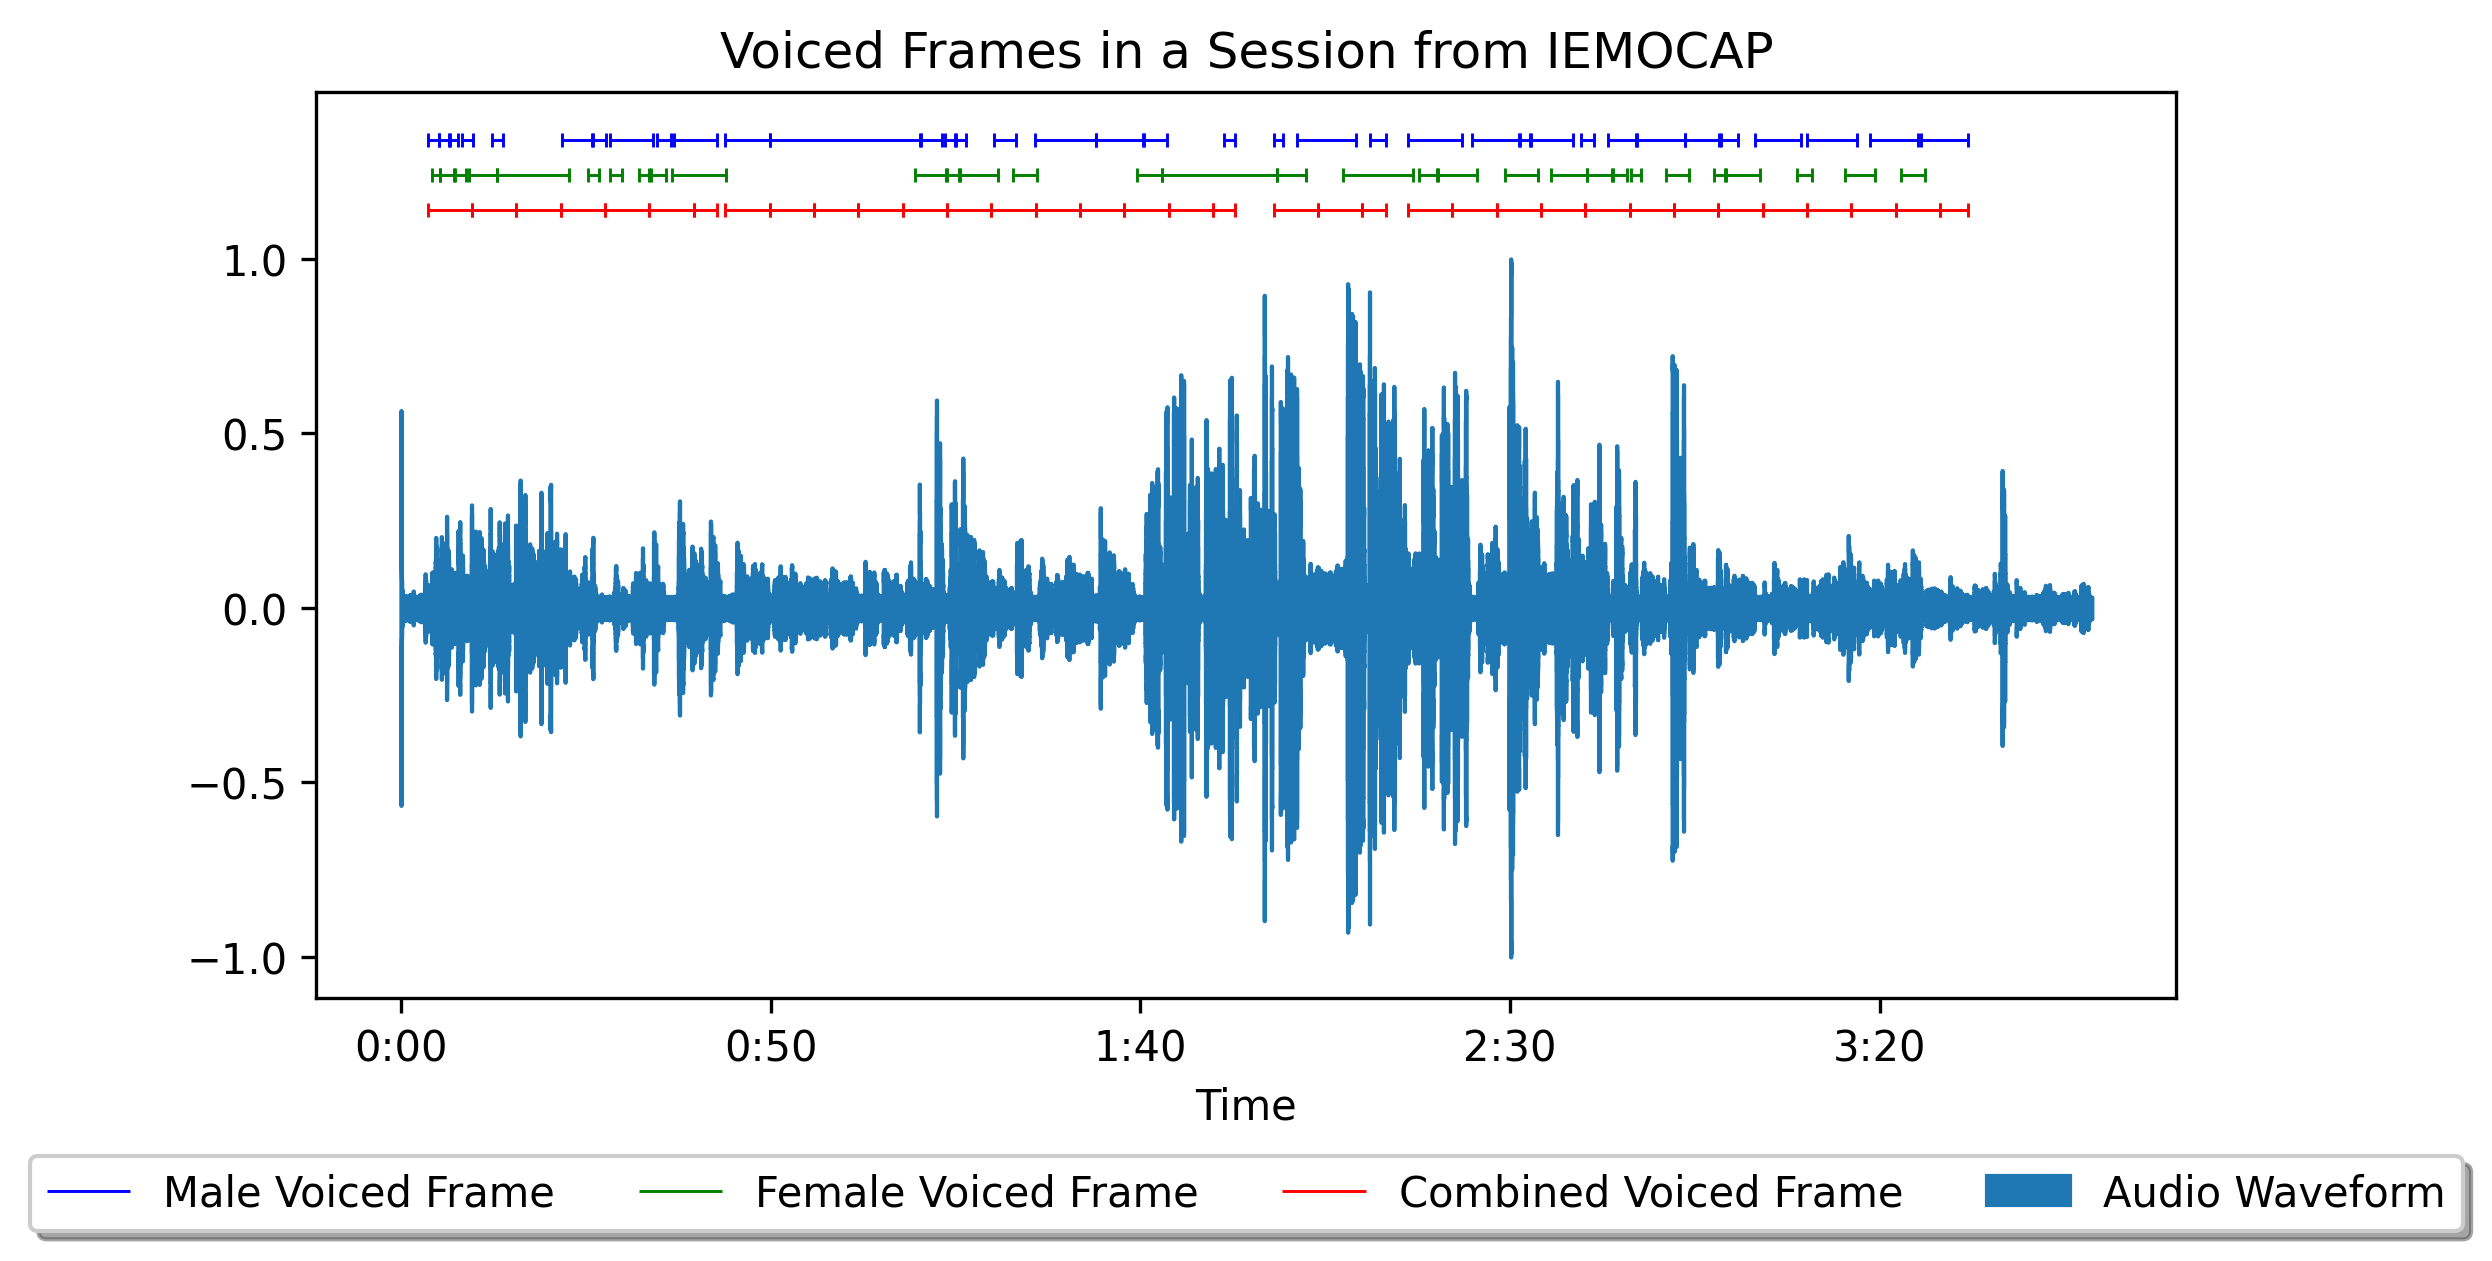

In [6]:
plt.figure(figsize=(8, 4))
plt.title("Voiced Frames in a Session from IEMOCAP")

y_len = np.max(y_to_print) * 0.02
y_space = np.max(y_to_print) * 0.1
upper_y, middle_y, lower_y = np.max(y_to_print)+ y_space + y_len*3, np.max(y_to_print)+ y_space + y_len*2, np.max(y_to_print)+ y_space + y_len

upper_y, middle_y, lower_y = upper_y + 0.2, middle_y + 0.2, lower_y + 0.2
start, end = male_voiced_frames[0]
plt.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='blue', label="Male Voiced Frame")
plt.vlines(start, color='blue', linewidth=.7, ymin=upper_y, ymax=lower_y)
plt.vlines(end, color='blue', linewidth=.7, ymin=upper_y, ymax=lower_y)
for start, end in male_voiced_frames[1:]:
    plt.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='blue')
    plt.vlines(start, color='blue', linewidth=.7, ymin=upper_y, ymax=lower_y)
    plt.vlines(end, color='blue', linewidth=.7, ymin=upper_y, ymax=lower_y)

upper_y, middle_y, lower_y = upper_y - 0.1, middle_y - 0.1, lower_y - 0.1
start, end = female_voiced_frames[0]
plt.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='green', label="Female Voiced Frame")
plt.vlines(start, color='green', linewidth=.7, ymin=upper_y, ymax=lower_y)
plt.vlines(end, color='green', linewidth=.7, ymin=upper_y, ymax=lower_y)
for start, end in female_voiced_frames[1:]:
    plt.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='green')
    plt.vlines(start, color='green', linewidth=.7, ymin=upper_y, ymax=lower_y)
    plt.vlines(end, color='green', linewidth=.7, ymin=upper_y, ymax=lower_y)

upper_y, middle_y, lower_y = upper_y - 0.1, middle_y - 0.1, lower_y - 0.1
start, end = processed_combined_voiced_frames[0]
plt.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='red', label="Combined Voiced Frame")
plt.vlines(start, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)
plt.vlines(end, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)
for start, end in processed_combined_voiced_frames[1:]:
    plt.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='red')
    plt.vlines(start, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)
    plt.vlines(end, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)

librosa.display.waveshow(y_to_print, sr=sr, label="Audio Waveform")

plt.legend(loc='lower center', bbox_to_anchor=(.5, -.28),
        ncol=4, fancybox=True, shadow=True)
plt.show()

# Speech Segmentation with SileroVAD

In [7]:
def read_wav_part_from_local(path: str, sr: float, start_s: float, duration_s: float):
    with wave.open(path, mode='rb') as wavread:
        start = int(start_s * sr)
        duration = int(duration_s * sr)
        wavread.setpos(start)
        return wavread.readframes(duration)

def process_bytes(y, FORMAT):
    y = np.frombuffer(y, FORMAT)
    if FORMAT == np.int32:
        abs_max = np.abs(y).max()
        y = y.astype('float32')
        if abs_max > 0:
            y *= 1/abs_max
        y = y.squeeze()
    elif FORMAT != np.float32:
        y = y.astype('float32')
    return y

def normalize_audio(y, sr):
    if sr != 16000:
        y = librosa.resample(y, sr, 16000)
    if NO_CHANNELS != 1:
        y = librosa.to_mono(y)
    return torch.from_numpy(y)

vad_model, _ = torch.hub.load(
    repo_or_dir='snakers4/silero-vad',
    model='silero_vad',
    force_reload=False
)
classifier_model = SERClassifier(traditional_ser=False, stratified=True)

FORMAT=np.int32
SAMPLE_RATE=16000
NO_CHANNELS=1
MIN_CONFIDENCE=0.5
MIN_DURATION=1
MAX_DURATION=6
STEP = 1

silero_voiced_frames = []
silero_confidences = []
pred_seg_emot = []
current_y, prev_start, prev_end = None, None, None
for start in np.arange(0, librosa.get_duration(y=y, sr=SAMPLE_RATE), STEP):
    wav = read_wav_part_from_local(audio_file_test, SAMPLE_RATE, start, STEP)
    wav = process_bytes(wav, FORMAT)
    wav = normalize_audio(wav, SAMPLE_RATE)

    confidence = vad_model(wav, SAMPLE_RATE).item()
    silero_confidences.append(confidence)

    end = start + STEP
    if confidence >= MIN_CONFIDENCE:
        if prev_end == None:
            current_y = wav
            prev_start, prev_end = start, end
        else:
            current_y = np.append(current_y, wav)
            prev_end = end
            if (end - prev_start) >= MAX_DURATION:
                pred_seg_emot.append(classifier_model.predict_segment(current_y))
                silero_voiced_frames.append((prev_start, prev_end))
                prev_start, prev_end, current_y = None, None, None
    elif prev_end:
        if (prev_end - prev_start) >= MIN_DURATION:
            pred_seg_emot.append(classifier_model.predict_segment(current_y))
            silero_voiced_frames.append((prev_start, prev_end))
        prev_start, prev_end, current_y = None, None, None

if (len(silero_voiced_frames) and silero_voiced_frames[-1] != (prev_start, prev_end) and prev_end) or ((not len(silero_voiced_frames)) and prev_end):
    if (prev_end - prev_start) > MIN_DURATION:
        pred_seg_emot.append(classifier_model.predict_segment(current_y))
        silero_voiced_frames.append((prev_start, prev_end))

Using cache found in C:\Users\Chico/.cache\torch\hub\snakers4_silero-vad_master


# Pipeline Results

In [ ]:
pd.DataFrame([y - x for x,y in silero_voiced_frames], columns=['Voice Frames']).describe()

,Voice Frames
count,44.000000
mean,4.545455
std,1.981948
min,1.000000
25%,3.000000
50%,6.000000
75%,6.000000
max,6.000000


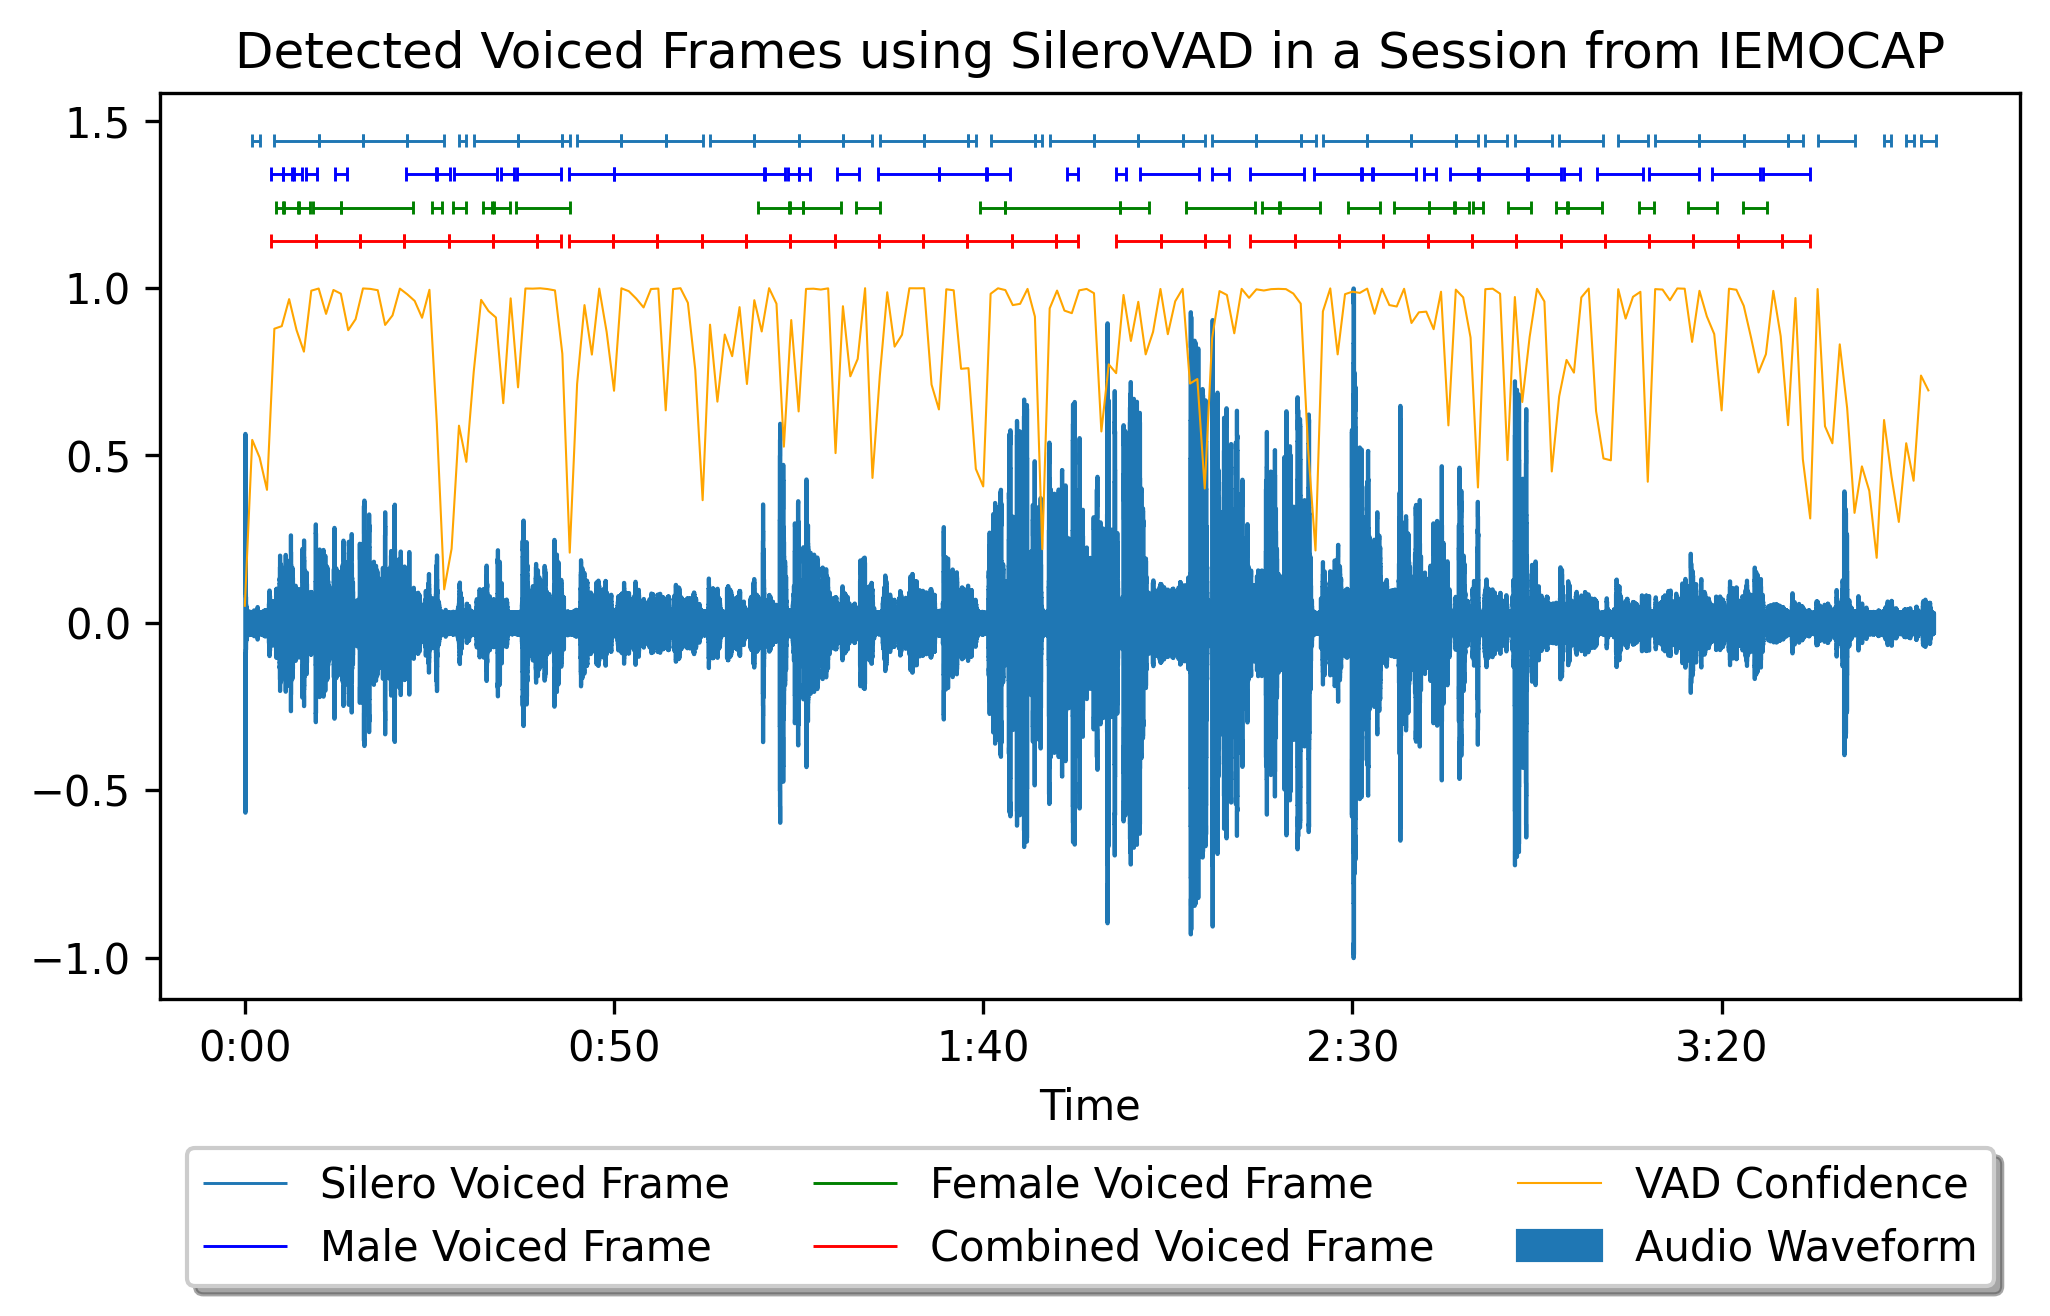

In [9]:
plt.figure(figsize=(8, 4))
plt.title("Detected Voiced Frames using SileroVAD in a Session from IEMOCAP")

y_len = np.max(y_to_print) * 0.02
y_space = np.max(y_to_print) * 0.1
upper_y, middle_y, lower_y = np.max(y_to_print)+ y_space + y_len*3, np.max(y_to_print)+ y_space + y_len*2, np.max(y_to_print)+ y_space + y_len

upper_y, middle_y, lower_y = upper_y + 0.3, middle_y + 0.3, lower_y + 0.3
start, end = silero_voiced_frames[0]
plt.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='tab:blue', label="Silero Voiced Frame")
plt.vlines(start, color='tab:blue', linewidth=.7, ymin=upper_y, ymax=lower_y)
plt.vlines(end, color='tab:blue', linewidth=.7, ymin=upper_y, ymax=lower_y)
for start, end in silero_voiced_frames[1:]:
    plt.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='tab:blue')
    plt.vlines(start, color='tab:blue', linewidth=.7, ymin=upper_y, ymax=lower_y)
    plt.vlines(end, color='tab:blue', linewidth=.7, ymin=upper_y, ymax=lower_y)


upper_y, middle_y, lower_y = upper_y - 0.1, middle_y - 0.1, lower_y - 0.1
start, end = male_voiced_frames[0]
plt.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='blue', label="Male Voiced Frame")
plt.vlines(start, color='blue', linewidth=.7, ymin=upper_y, ymax=lower_y)
plt.vlines(end, color='blue', linewidth=.7, ymin=upper_y, ymax=lower_y)
for start, end in male_voiced_frames[1:]:
    plt.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='blue')
    plt.vlines(start, color='blue', linewidth=.7, ymin=upper_y, ymax=lower_y)
    plt.vlines(end, color='blue', linewidth=.7, ymin=upper_y, ymax=lower_y)

upper_y, middle_y, lower_y = upper_y - 0.1, middle_y - 0.1, lower_y - 0.1
start, end = female_voiced_frames[0]
plt.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='green', label="Female Voiced Frame")
plt.vlines(start, color='green', linewidth=.7, ymin=upper_y, ymax=lower_y)
plt.vlines(end, color='green', linewidth=.7, ymin=upper_y, ymax=lower_y)
for start, end in female_voiced_frames[1:]:
    plt.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='green')
    plt.vlines(start, color='green', linewidth=.7, ymin=upper_y, ymax=lower_y)
    plt.vlines(end, color='green', linewidth=.7, ymin=upper_y, ymax=lower_y)

upper_y, middle_y, lower_y = upper_y - 0.1, middle_y - 0.1, lower_y - 0.1
start, end = processed_combined_voiced_frames[0]
plt.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='red', label="Combined Voiced Frame")
plt.vlines(start, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)
plt.vlines(end, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)
for start, end in processed_combined_voiced_frames[1:]:
    plt.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='red')
    plt.vlines(start, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)
    plt.vlines(end, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)

plt.plot(silero_confidences, label="VAD Confidence", color="orange", linewidth=0.5)

librosa.display.waveshow(y_to_print, sr=sr, label="Audio Waveform")

plt.legend(loc='lower center', bbox_to_anchor=(.5, -.34),
        ncol=3, fancybox=True, shadow=True)
plt.show()

In [10]:
segment_no = 5
Audio(y[int(silero_voiced_frames[segment_no][0]*sr):int(silero_voiced_frames[segment_no][1]*sr)], sr)

# Classifying the File Segments

In [11]:
print(f"File Annotated Emotions:")
pd.DataFrame(seg_emot).groupby([0]).agg({0: ['count']})

File Annotated Emotions:


,0
,count
0,
ang,20
fru,7
hap,2
neu,30
sur,2
xxx,6


In [12]:
print(f"Predicted Emotions From Pipeline Segments:")
pd.DataFrame(pred_seg_emot).groupby([0]).agg({0: ['count']})

Predicted Emotions From Pipeline Segments:


,0
,count
0,
happiness,19
neutral,24
sadness,1


# Classifying All IEMOCAP Files

In [13]:
seg_emot = []
pred_seg_emot = []

for file_path in tqdm(glob.glob(AUDIO_DIR+'/Session[0-9]*/dialog/EmoEvaluation/*.txt')):
    emotions_test_file = open(file_path)
    for line in emotions_test_file:
        if line[0] == '[':
            seg_emot.append(line.split()[4])
    emotions_test_file.close()

    temp = file_path.split("\\")
    audio_file = AUDIO_DIR+f'/Session{temp[-4][-1]}/dialog/wav/{temp[-1][:-3]}wav'
    y, sr = librosa.load(audio_file, sr=16000)

    
    silero_voiced_frames = []
    current_y, prev_start, prev_end = None, None, None
    for start in np.arange(0, librosa.get_duration(y=y, sr=SAMPLE_RATE), STEP):
        wav = read_wav_part_from_local(audio_file, SAMPLE_RATE, start, STEP)
        wav = process_bytes(wav, FORMAT)
        wav = normalize_audio(wav, SAMPLE_RATE)

        # Input audio chunk is too short
        if SAMPLE_RATE / wav.shape[0] > 31.25:
            if prev_end and (prev_end - prev_start) >= MIN_DURATION:
                pred_seg_emot.append(classifier_model.predict_segment(current_y))
                silero_voiced_frames.append((prev_start, prev_end))
            prev_start, prev_end, current_y = None, None, None
            continue

        confidence = vad_model(wav, SAMPLE_RATE).item()

        end = start + STEP
        if confidence >= MIN_CONFIDENCE:
            if prev_end == None:
                current_y = wav
                prev_start, prev_end = start, end
            else:
                current_y = np.append(current_y, wav)
                prev_end = end
                if (end - prev_start) >= MAX_DURATION:
                    pred_seg_emot.append(classifier_model.predict_segment(current_y))
                    silero_voiced_frames.append((prev_start, prev_end))
                    prev_start, prev_end, current_y = None, None, None
        elif prev_end:
            if (prev_end - prev_start) >= MIN_DURATION:
                pred_seg_emot.append(classifier_model.predict_segment(current_y))
                silero_voiced_frames.append((prev_start, prev_end))
            prev_start, prev_end, current_y = None, None, None

    if (len(silero_voiced_frames) and silero_voiced_frames[-1] != (prev_start, prev_end) and prev_end) or ((not len(silero_voiced_frames)) and prev_end):
        if (prev_end - prev_start) >= MIN_DURATION:
            pred_seg_emot.append(classifier_model.predict_segment(current_y))
            silero_voiced_frames.append((prev_start, prev_end))
    current_y, prev_start, prev_end = None, None, None

 30%|██▉       | 45/151 [15:43<51:30, 29.15s/it]  C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1508
  return f(*args, **kwargs)
 95%|█████████▌| 144/151 [2:20:24<13:31, 115.98s/it]  

In [ ]:
print(f"All Files Annotated Emotions:")
pd.DataFrame(seg_emot).groupby([0]).agg({0: ['count']})

All Files Annotated Emotions:


,0
,count
0,
ang,1103
dis,2
fea,40
fru,1849
hap,1636
neu,1708
oth,3
sad,1084


In [118]:
print(f"All Files Predicted Emotions From Pipeline:")
pd.DataFrame(pred_seg_emot).groupby([0]).agg({0: ['count']})

All Files Predicted Emotions From Pipeline:


,0
,count
0,
anger,2213
happiness,3092
neutral,1633
sadness,737


In [ ]:
print(f"All Files Predicted Emotions From Pipeline:")
pd.DataFrame(pred_seg_emot).groupby([0]).agg({0: ['count']})